In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.111472  0.717948 -0.575830 -0.499110  0.270507 -0.280863  0.958542   
  1   0.170502 -0.185440 -0.415561  0.454271  0.291468  0.314253  1.031667   
  2   0.294754 -0.691595 -0.533646 -0.613822  0.459059 -0.478077 -0.247114   
  3  -0.273903 -0.979975 -0.257695 -1.022363 -0.350611  0.409993  0.517740   
  4  -1.222110 -0.979824 -0.985087 -0.740648  0.700467 -0.222580 -0.239124   
  5  -0.020005  0.029585 -0.416944 -0.214066 -0.184054  0.315718  0.675317   
  6  -0.805316 -0.918076  0.078432 -0.809469  0.106687  0.965545  1.351689   
  7  -0.753497 -0.354651 -0.196782  0.181041  0.361515 -0.190105  0.924004   
  8  -0.480364 -0.565904 -0.188957 -0.368612 -0.729124 -0.604287  0.129943   
  9  -0.821510  0.076014 -0.681874 -0.393779 -1.238964  1.359733  1.528326   
  10 -0.807558  1.340109  0.580231 -0.247668 -0.197430 -0.249925  1.021862   
  11  0.082130 -0.991000 -0.224067 -0.277798 -0.222237  0.150286  0.436227   
  12  0.376439  0.874628  0.811695  0.765757 -0.471393  0.244416  0.067104   
  13 -0.126987 -0.635857  0.602268 -1.229736 -0.098224  0.274426 -0.000943   
  14 -0.063472 -0.022550  1.094224 -0.875400 -0.704961 -0.357944  1.271893   
  15  0.156273  0.321743 -0.402581 -0.986734  0.393191  0.297468  0.038957   
  16 -0.338392 -0.340127  0.162916 -0.360686  0.220314  0.061708  0.523818   
  17 -0.327323 -0.155007  0.198520 -0.106258 -0.048616 -0.447553  0.277768   
  18 -0.765859 -0.416360  0.474350 -0.234638  0.071018  0.400967  0.400578   
  19 -0.384311 -0.004520 -0.319855  0.282207  0.808590 -0.148487  0.108340   
  20  0.709580 -0.454727  0.456852  0.999292 -0.431844 -0.268235  0.018561   
  21 -0.469682  0.450394 -0.870794  0.273823  0.671832 -0.052218  0.951888   
  22 -0.412124  0.210863 -0.352495 -0.759200  0.425334 -0.114683  0.322543   
  23 -0.321585  0.145695 -0.129469  0.364402  0.097114 -0.927863  0.299767   
  24  0.310150 -0.478505 -0.347626 -0.635653  0.097758  0.685192  0.996025   
1 0  -0.147123  1.521878  0.340215 -0.596310 -0.368456 -0.630529  0.659439   
  1  -0.923142  0.127412  0.086112 -0.150267 -0.193816  0.283057  0.626181   
  2  -0.107789  0.544861 -0.401471 -0.635955 -0.145301 -0.257331  0.541141   
  3  -0.544870  0.001188 -0.037066 -0.689187 -0.687712 -1.072136  0.525011   
  4  -0.368594  0.539132  0.617652  0.339404 -1.486590 -0.300694  0.074763   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.470637  0.634538 -0.287645  ...  0.282042 -0.057236 -0.361806   
  1  -0.180448  0.638589  0.489766  ... -0.391540 -0.652732 -1.370947   
  2  -0.257484  0.020129 -0.408048  ... -0.802724  0.955329 -0.449739   
  3  -0.592079  0.131414 -0.455332  ... -0.988390 -0.710733 -0.135832   
  4  -0.395867  0.810510 -0.550689  ...  0.089589 -0.564681 -0.345725   
  5   0.522180 -0.077153  0.374281  ... -0.244889 -1.098667  0.265793   
  6   0.184639 -0.676421  0.610539  ... -1.113418 -0.757685 -0.148449   
  7  -1.214393 -0.654895  0.190233  ... -0.426971 -0.225009 -0.960190   
  8  -0.555525  0.197001 -0.391280  ...  0.365513 -0.082929  0.027898   
  9   0.043056  0.749727  0.300419  ... -0.543814  0.066719 -0.065390   
  10  0.899920  0.219232  0.035220  ... -0.572873 -0.017002 -0.850740   
  11  0.037170  0.528566  0.678501  ... -0.640187 -1.276054 -0.885325   
  12 -0.441979 -0.510273 -0.852613  ... -0.944191 -0.456088  0.534926   
  13 -1.036423  0.347455  0.020031  ... -1.258123  0.601225  0.269917   
  14  0.180470 -0.322626  0.362806  ... -2.103647 -0.604687  1.154524   
  15  0.210241  0.837525  1.105464  ... -0.621329 -0.685376  0.095988   
  16 -0.196595  0.132617 -0.189771  ... -0.824437 -0.294245 -0.982633   
  17  0.222148 -0.453765  0.357222  ...  0.849944  0.433148  0.808661   
  18 -0.638829  0.758743  0.704170  ... -0.835346  0.137547  0.359509   
  19  0.205665  1.012900  0.916804  ... -1.232469 -0.394731 -0.910145   
  20 -0.612497 -0.474967  0.222171  ... -0.228394 -0.705249 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|    2.5 %    97.5 %
D  0.996814  0.036329  27.438347  9.569830e-166  0.92561  1.068018


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



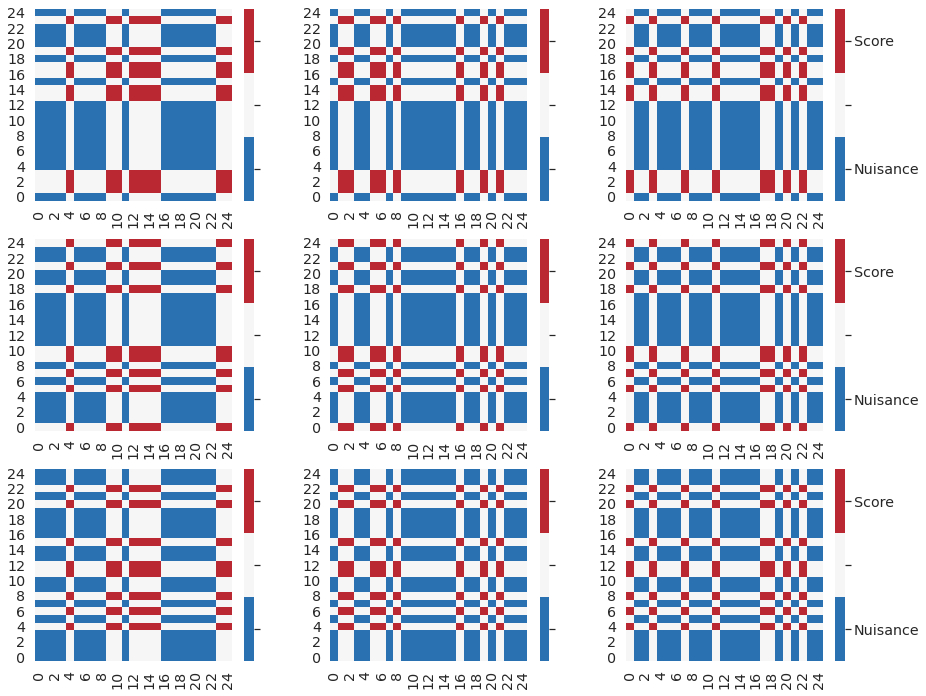

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



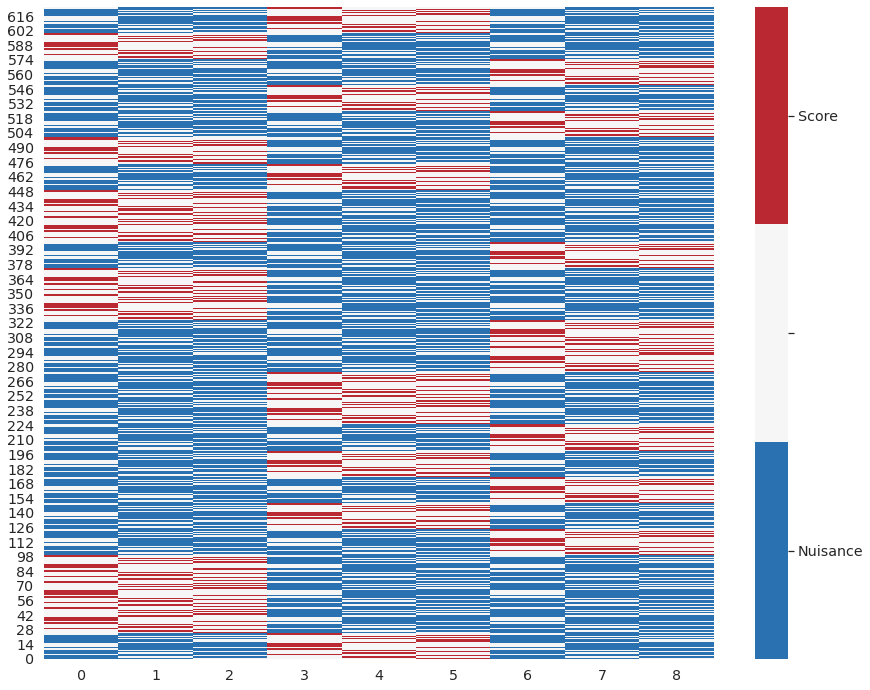

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])